# Assignment 3: Convolutional Neural Networks

In [1]:
%matplotlib ipympl

import torch
from torch import nn, optim

import torch.nn.functional as F
import lightning as L
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from math import floor
import sys, os

sys.path.append(os.getcwd())
from a03helper import *

seed_everything(42)

Seed set to 42


42

## Task 1: Simple CNN

In [2]:
class ConvBlock(nn.Module):
    """A convolution block as used in the CS231n web demo."""

    def __init__(
        self,
        in_channels=3,
        intermediate_channels=16,
        out_channels=16,
        conv_kernel_size=3,
        pool_kernel_size=2,
        activation_fn=F.relu,
    ):
        super().__init__()

        # Define the individual layers here:
        # First convolution:  self.conv1
        # Second convolution: self.conv2
        # Max-pooling:        self.pool
        # (will be accessed by these names later on)
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=conv_kernel_size, padding="same")
        self.conv2 = nn.Conv2d(intermediate_channels, out_channels, kernel_size=conv_kernel_size, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size)
        self.activation_fn = activation_fn

        
    def forward(self, x):
        # Note that inputs have shape: batch size x channels x width x height
        out = self.activation_fn(self.conv1(x))
        out = self.activation_fn(self.conv2(out))
        out = self.pool(out)
        return out

# Images of the CIFAR-10 dataset are of shape:
# [color_channels, height, width] = [3, 32, 32]
batch = torch.randn(2, 3, 32, 32)
block = ConvBlock()
batch_out = block(batch)
print(batch_out.shape)

# Should yield:
# torch.Size([2, 16, 16, 16])

torch.Size([2, 16, 16, 16])


In [3]:
class SimpleCNN(nn.Module):
    def __init__(
        self,
        num_conv_blocks=3,
        conv_out_channels=16,
        conv_kernel_size=3,
        activation_fn=F.relu,
    ):
        super().__init__()
        # Store conv blocks inside this module list (will used later). To do so, use the
        # append() method.
        self.conv_blocks = nn.ModuleList()
        
        in_channels = 3
        
        for _ in range(num_conv_blocks):
            self.conv_blocks.append(
                ConvBlock(in_channels=in_channels, intermediate_channels=conv_out_channels, out_channels=conv_out_channels)
            )
            in_channels = conv_out_channels
        final_feature_size = 32 // (2 ** num_conv_blocks)
        self.linear = nn.Linear(conv_out_channels * final_feature_size * final_feature_size, 10)


    def forward(self, x):
        # Output the softmax scores (i.e., do not apply the softmax function) for the
        # images in the batch
        for block in self.conv_blocks:
            x = block(x)
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out

In [4]:
# Test your implementation
model = SimpleCNN()
batch = torch.randn(2, 3, 32, 32)
batch_out = model(batch)
print(batch_out)


# Should yield an ouput such as:
# tensor([[-0.0433, -0.0400,  0.0532,  0.0348, -0.0274,  0.0176, -0.0505,  0.0557,
#           0.0335,  0.0585],
#         [-0.0425, -0.0385,  0.0518,  0.0349, -0.0263,  0.0188, -0.0502,  0.0548,
#           0.0329,  0.0582]], grad_fn=<AddmmBackward0>)

tensor([[ 0.0192, -0.0786,  0.0456, -0.0245,  0.0561, -0.0086,  0.0115,  0.0333,
         -0.0017, -0.0062],
        [ 0.0184, -0.0787,  0.0457, -0.0230,  0.0546, -0.0095,  0.0117,  0.0332,
         -0.0004, -0.0061]], grad_fn=<AddmmBackward0>)


## Task 2: Lightning

In [5]:
class LitBaseCNN(L.LightningModule):
    def __init__(self, lr=0.001, **kwargs):
        super().__init__()
        self.model = self.initialize_model(**kwargs)
        self.lr = lr

    def initialize_model(self, **kwargs):
        """
        This method will be implemented later on. Do not change.
        """
        raise NotImplementedError("method 'initialize_model' not implemented")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        # In addition to returning the training loss, also log it as 'train_loss'.
        images, targets = batch
        outputs = self.model(images)
        loss = F.cross_entropy(outputs, targets)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        return self._eval(batch, mode="val")

    def test_step(self, batch, batch_idx):
        return self._eval(batch, "test")

    def _eval(self, batch, mode="val"):
        """
        This method is used both for validation and testing
        (cf. validation_step and test_step).
        """
        # Log the loss as `{mode}_loss`, the accuracy as
        # `{mode}_acc` and additionally as `hp_metric`.
        images, targets = batch
        outputs = self.model(images)
        loss = F.cross_entropy(outputs, targets)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == targets).sum().item()
        accuracy = correct / targets.size(0)
        self.log(f'{mode}_loss', loss, prog_bar=True)
        self.log(f'{mode}_acc', accuracy, prog_bar=True)
        self.log('hp_metric', accuracy, prog_bar=True)
        return loss

In [6]:
class LitSimpleCNN(LitBaseCNN):
    def initialize_model(
        self,
        num_conv_blocks=3,
        conv_out_channels=16,
        conv_kernel_size=3,
        activation_fn=F.relu,
    ):
        return SimpleCNN(
            num_conv_blocks, conv_out_channels, conv_kernel_size, activation_fn
        )

In [7]:
simple_cnn = LitSimpleCNN(num_conv_blocks=2, conv_out_channels=16)
print(simple_cnn)

# Should produce:
# LitSimpleCNN(
#   (model): SimpleCNN(
#     (conv_blocks): ModuleList(
#       (0): ConvBlock(
#         (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
#         (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
#         (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#       )
#       (1): ConvBlock(
#         (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
#         (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
#         (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#       )
#     )
#     (linear): Linear(in_features=1024, out_features=10, bias=True)
#   )
# )

LitSimpleCNN(
  (model): SimpleCNN(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (linear): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [8]:
# This is how to use the model manually
# (alternatively, implement a forward() method, see
# https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#inference-in-research ).
batch = torch.randn(2, 3, 32, 32)
model = LitSimpleCNN().model
batch_out = model(batch)
print(batch_out)

# Should yield:
# tensor([[ 0.0347,  0.0706,  0.0101, -0.0390,  0.0411, -0.0452, -0.0055,  0.0297,
#          -0.0663, -0.0240],
#         [ 0.0339,  0.0697,  0.0110, -0.0393,  0.0408, -0.0444, -0.0060,  0.0294,
#          -0.0650, -0.0240]], grad_fn=<AddmmBackward0>)

tensor([[ 0.0347,  0.0706,  0.0101, -0.0390,  0.0411, -0.0452, -0.0055,  0.0297,
         -0.0663, -0.0240],
        [ 0.0339,  0.0697,  0.0110, -0.0393,  0.0408, -0.0444, -0.0060,  0.0294,
         -0.0650, -0.0240]], grad_fn=<AddmmBackward0>)


In [9]:
class CifarDataModule(L.LightningDataModule):
    def __init__(self, data_dir="raw", batch_size=32, num_workers=0):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        # This downloads the data if not yet present, but does not yet associate it with
        # this module (see documentation).
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        transforms = v2.Compose(
            [
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(
                    (0.4913, 0.4821, 0.4465),
                    (0.2470, 0.2434, 0.2615),
                ),
            ]
        )

        if stage == "fit":
            # This loads the training data
            cifar_train = CIFAR10(self.data_dir, True, transforms)

            # Split training data into 80% training and 20% validation data and assign
            # to self.train_data and self.val_data
            train_len = int(0.8 * len(cifar_train))
            val_len = len(cifar_train) - train_len
            self.train_data, self.val_data = random_split(cifar_train, [train_len, val_len])            
            
        elif stage == "test":
            # This loads the test data
            self.test_data = CIFAR10(self.data_dir, False, transforms)

    def train_dataloader(self):
        # Return train dataloader with `self.batch_size` and `self.num_workers`
        # and shuffling enabled.
        return DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        # Return validation dataloader with `self.batch_size` and `self.num_workers`.
        return DataLoader(self.val_data, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        # Return test dataloader with `self.batch_size` and `self.num_workers`.
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers)

dm = CifarDataModule()
dm.prepare_data()
dm.setup("fit")
print(len(dm.train_dataloader().dataset))
# Should yield:
# 40000

Files already downloaded and verified
Files already downloaded and verified
40000


## Task 3: Training with Lightning and TensorBoard

In [10]:
# Define hyperparameters (hp) and initialize modules
model_hp = dict(
    num_conv_blocks=3,
    conv_out_channels=16,
    conv_kernel_size=5,
    activation_fn=F.relu,
    lr=0.001,
)
other_hp = dict(
    batch_size=32,
    max_epochs=4,
)
simple_cnn = LitSimpleCNN(**model_hp)
dm = CifarDataModule(batch_size=other_hp["batch_size"])

In [11]:
# Log hyperparameters using TensorBoard
logger = TensorBoardLogger(
    save_dir="logs", name="simple_cnn"
)  # do not change location in JHub
logger.log_hyperparams({**model_hp, **other_hp})

In [12]:
# Create a trainer
#Optional. Check out the documentation of the Lightning Trainer and tweak your training setup by trying out different settings.

trainer = L.Trainer(
    deterministic=True,
    fast_dev_run=False,  # change this to False for actual training
    max_epochs=other_hp["max_epochs"],
    logger=logger,
    check_val_every_n_epoch=1,    
    # add early stopping    
    callbacks=[EarlyStopping(monitor='val_acc', patience=2)]
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
# And run it
trainer.fit(simple_cnn, datamodule=dm)
# Should yield an accuracy of 65 % after 4 epochs.

Files already downloaded and verified
Files already downloaded and verified



  | Name  | Type      | Params
------------------------------------
0 | model | SimpleCNN | 14.6 K
------------------------------------
14.6 K    Trainable params
0         Non-trainable params
14.6 K    Total params
0.058     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### TensorBoard

There are a few options to run TensorBoard depending on your environment.

#### Jupyter Hub

Open up a new tab inside JupyterHub. Then, open TensorBoard.

#### Local environment

Open a shell inside this directory. Run:

```sh
tensorboard --logdir logs
```

Then, open your browser and navigate to: [http://localhost:6006](http://localhost:6006)

#### Docker Container

Open a shell inside your running container:

```sh
docker exec -it <container> /bin/bash
```
where the container can be identified using `docker ps`. From there, proceed as
in a local environment (see above).

#### Inside Jupyter (but not on Jupyter Hub)

Create a new code cell with the following contents and execute:

```sh
%load_ext tensorboard
%tensorboard --logdir logs
```

In [14]:
# This is how you would use the test dataset (after you are done with your model
# selection):
trainer.test(simple_cnn, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           0.5968000292778015
        test_acc            0.5968000292778015
        test_loss           1.1287577152252197
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1287577152252197,
  'test_acc': 0.5968000292778015,
  'hp_metric': 0.5968000292778015}]

## Task 4: Visualization
model = LitSimpleCNN.load_from_checkpoint(
    os.path.join("checkpoints", "simple-cnn.ckpt"),
    num_conv_blocks=2,
    conv_out_channels=30,
    conv_kernel_size=4,
    lr=0.001,
)
trainer.test(model, datamodule=dm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

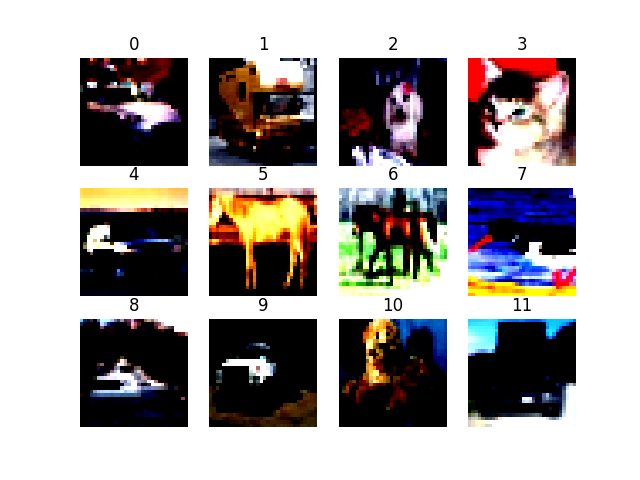

In [15]:
# Obtain images from CIFAR-10 dataset
dm.setup("fit")
train_data = dm.train_data

# Plot the first 12 images
fig, axs = plt.subplots(nrows=3, ncols=4)
for i in range(12):
    row = floor(i / 4)
    col = i % 4
    axs[row, col].imshow(train_data[i][0].permute(1, 2, 0))
    axs[row, col].set_title(i)
    axs[row, col].axis("off")

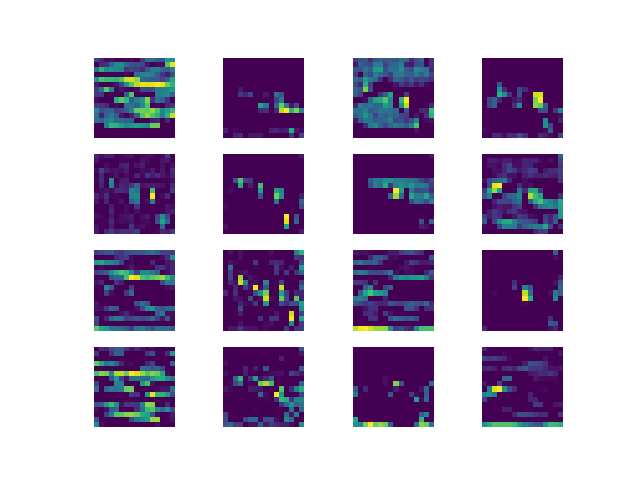

In [16]:
# Obtain first block's output of a single image and plot
item, label = train_data[7]  # choose the image that you find most promising to analyze
block0 = simple_cnn.model.conv_blocks[0].cpu()
with torch.no_grad():
    out0 = block0(item)
plot_conv_module_output(out0)

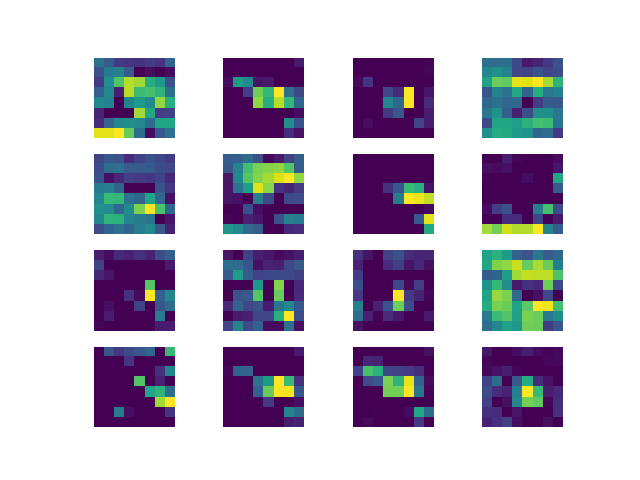

In [17]:
# Obtain second's block output for the same image and plot
block1 = simple_cnn.model.conv_blocks[1].cpu()
with torch.no_grad():
    out1 = block1(out0)
plot_conv_module_output(out1)

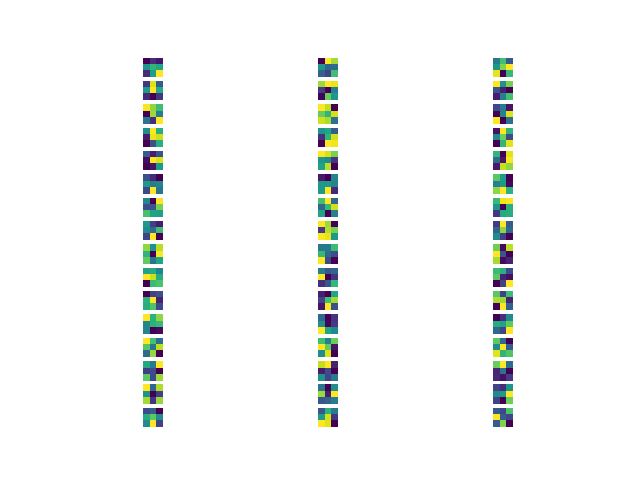

In [19]:
# Plot filters from first convolutional layer (columns refer to input channels, rows
# output channels)
conv1 = block0.conv1.weight.detach()
plot_kernels(conv1)

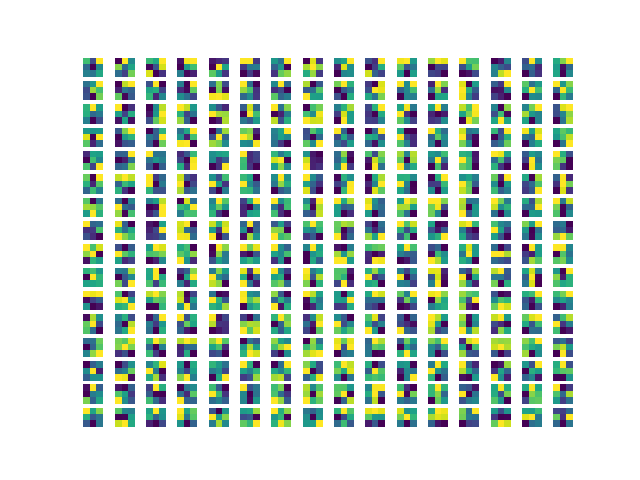

In [20]:
# Plot filters from second convolutional layer
conv1 = block0.conv2.weight.detach()
plot_kernels(conv1)

## Task 5: ConvNeXt

In [23]:
class LayerNormChannels(nn.Module):
    """Utility module for the layer norms."""

    def __init__(self, C):
        super().__init__()
        self.norm = nn.LayerNorm(C)

    def forward(self, x):
        x1 = x.transpose(1, -1)
        x2 = self.norm(x1)
        x3 = x2.transpose(-1, 1)
        return x3


batch = torch.randn(2, 3, 32, 32)
norm_module = LayerNormChannels(3)
batch_out = norm_module(batch)
print(batch_out.shape)

torch.Size([2, 3, 32, 32])


In [24]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, C, conv_kernel_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(C),
            nn.GELU(),
            nn.Conv2d(C, C, kernel_size=conv_kernel_size, stride=1, padding="same", groups=C),
            nn.GELU(),
            nn.Conv2d(C, 4 * C, kernel_size=1, stride=1),
            nn.GELU(),
            nn.Conv2d(4 * C, C, kernel_size=1, stride=1))

    def forward(self, x):
        return self.block(x) + x

In [25]:
class ConvNextDownsample(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.downsample = nn.Conv2d(C, 2 * C, kernel_size=2, stride=2)

    def forward(self, x):
        return self.downsample(x)

In [26]:
class ConvNeXtStem(nn.Module):
    def __init__(self, in_channels=3, D=16, conv_kernel_size=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, D, kernel_size=conv_kernel_size, stride=1, padding=conv_kernel_size//2),
            nn.GELU()
        )
        
    def forward(self, x):
        return self.stem(x)

In [27]:
class ConvNeXtStage(nn.Module):
    def __init__(self, C, conv_kernel_size, downsample=True):
        super().__init__()
        self.stage = nn.Sequential(
            ConvNeXtBlock(C, conv_kernel_size),
            ConvNeXtBlock(C, conv_kernel_size)
        )

    def forward(self, x):
        return self.stage(x) + x

In [28]:
class ConvNeXt(nn.Module):
    def __init__(self, D=16, conv_kernel_size=3, num_stages=2):
        super().__init__()
        self.stem = ConvNeXtStem(D=D)
        self.stages = nn.ModuleList(
            [ConvNeXtStage(D, conv_kernel_size) for _ in range(num_stages)]
        )
        self.linear = nn.Linear(8192, 10)

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        x = x.view(x.size(0), -1)
        return self.linear(x)

In [29]:
model = ConvNeXt(D=16)
print(model)
# Should yield:
# ConvNeXt(
#   (stem): ConvNeXtStem(
#     (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
#   )
#   (stages): ModuleList(
#     (0): ConvNeXtStage(
#       (stage): Sequential(
#         (0): Identity()
#         (1): ConvNeXtBlock(
#           (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=16)
#           (layer_norm): LayerNormChannels(
#             (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
#           )
#           (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
#           (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
#         )
#         (2): ConvNeXtBlock(
#           (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=16)
#           (layer_norm): LayerNormChannels(
#             (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
#           )
#           (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
#           (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
#         )
#       )
#     )
#     (1): ConvNeXtStage(
#       (stage): Sequential(
#         (0): ConvNextDownsample(
#           (layer_norm): LayerNormChannels(
#             (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
#           )
#           (conv): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
#         )
#         (1): ConvNeXtBlock(
#           (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32)
#           (layer_norm): LayerNormChannels(
#             (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
#           )
#           (conv2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
#           (conv3): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
#         )
#         (2): ConvNeXtBlock(
#           (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32)
#           (layer_norm): LayerNormChannels(
#             (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
#           )
#           (conv2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
#           (conv3): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
#         )
#       )
#     )
#   )
#   (linear): Linear(in_features=8192, out_features=10, bias=True)
# )

ConvNeXt(
  (stem): ConvNeXtStem(
    (stem): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
    )
  )
  (stages): ModuleList(
    (0-1): 2 x ConvNeXtStage(
      (stage): Sequential(
        (0): ConvNeXtBlock(
          (block): Sequential(
            (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (1): GELU(approximate='none')
            (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=16)
            (3): GELU(approximate='none')
            (4): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (5): GELU(approximate='none')
            (6): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ConvNeXtBlock(
          (block): Sequential(
            (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (1): GELU(approximate='none')
            (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

In [27]:
batch = torch.randn(2, 3, 32, 32)
batch_out = model(batch)
print(batch_out.shape)


# Should yield:
# torch.Size([2, 10])

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
class LitConvNeXt(LitBaseCNN):
    def initialize_model(self, C, conv_kernel_size, num_stages):
        return ConvNeXt(
            C,
            conv_kernel_size,
            num_stages,
        )

In [ ]:
model_hp = dict(
    lr=0.001,
    C=16,
    conv_kernel_size=7,
    num_stages=4,
)

lit_convnext = LitConvNeXt(**model_hp)

other_hp = dict(
    batch_size=32,
    max_epochs=5,
)

dm = CifarDataModule(batch_size=other_hp["batch_size"])

logger = TensorBoardLogger(
    save_dir="logs", name="convnext"
)  # do not change directory in JHub
logger.log_hyperparams({**model_hp, **other_hp})

trainer = L.Trainer(
    deterministic=True,
    fast_dev_run=False,
    max_epochs=other_hp["max_epochs"],
    logger=logger,
    check_val_every_n_epoch=1,
)
trainer.fit(lit_convnext, datamodule=dm)

In [ ]:
trainer.test(lit_convnext, datamodule=dm)
# Should reach a bit less than 70% accuracy